# Implementing Transformers in PyTorch with HuggingFace

**Introduction to Deep Learning (BioE 394E)**  
(Adapted from examples by [HugghingFace Quickstart](https://huggingface.co/transformers/v1.1.0/quickstart.html) and [HugghingFace Sentiment Analysis](https://huggingface.co/blog/sentiment-analysis-python).

## Import tokenizer and encode some text for a masked LM task

In [1]:
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize input
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = tokenizer.tokenize(text)

# Mask a token that we will try to predict back with `BertForMaskedLM`
masked_index = 8
tokenized_text[masked_index] = '[MASK]'

# Convert token to vocabulary indices
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
# Define sentence A and B indices associated to 1st and 2nd sentences (see paper)
segments_ids = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

print( tokenized_text )

['[CLS]', 'who', 'was', 'jim', 'henson', '?', '[SEP]', 'jim', '[MASK]', 'was', 'a', 'puppet', '##eer', '[SEP]']


## Import pre-trained BERT model and encode text

In [2]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')

# Set the model in evaluation mode to desactivate the DropOut modules
model.eval()

# If you have a GPU, put everything on cuda
tokens_tensor = tokens_tensor.to('cpu')
segments_tensors = segments_tensors.to('cpu')
model.to('cpu')

# Predict hidden states features for each layer
with torch.no_grad():
    # See the models docstrings for the detail of the inputs
    outputs = model(tokens_tensor, token_type_ids=segments_tensors)
    # PyTorch-Transformers models always output tuples.
    # See the models docstrings for the detail of all the outputs
    # In our case, the first element is the hidden state of the last layer of the Bert model
    encoded_layers = outputs[0]

# We have encoded our input sequence in a FloatTensor of shape (batch size, sequence length, model hidden dimension)
encoded_layers.shape

torch.Size([1, 14, 768])

## Make prediction with pre-trained BERT model

In [3]:
# Load pre-trained model (weights)
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
model.eval()

# If you have a GPU, put everything on cuda
tokens_tensor = tokens_tensor.to('cpu')
segments_tensors = segments_tensors.to('cpu')
model.to('cpu')

# Predict all tokens
with torch.no_grad():
    outputs = model(tokens_tensor, token_type_ids=segments_tensors)
    predictions = outputs[0]

# confirm we were able to predict 'henson'
predicted_index = torch.argmax(predictions[0, masked_index]).item()
predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]

predicted_token

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


'henson'

## Import tokenizer from GPT2

In [4]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load pre-trained model tokenizer (vocabulary)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Encode a text inputs
text = "Who was Jim Henson ? Jim Henson was a"
indexed_tokens = tokenizer.encode(text)

# Convert indexed tokens in a PyTorch tensor
tokens_tensor = torch.tensor([indexed_tokens])

## Make prediction with GPT2

In [5]:
# Load pre-trained model (weights)
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Set the model in evaluation mode to desactivate the DropOut modules
model.eval()

# If you have a GPU, put everything on cuda
tokens_tensor = tokens_tensor.to('cpu')
model.to('cpu')

# Predict all tokens
with torch.no_grad():
    outputs = model(tokens_tensor)
    predictions = outputs[0]

# get the predicted next sub-word (in our case, the word 'man')
predicted_index = torch.argmax(predictions[0, -1, :]).item()
predicted_text = tokenizer.decode(indexed_tokens + [predicted_index])
predicted_text

'Who was Jim Henson? Jim Henson was a man'

## Sentiment analysis

In [6]:
from datasets import load_dataset
imdb = load_dataset("imdb")

In [7]:
small_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(1000))])
small_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(300))])

In [8]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [9]:
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)
 
tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test = small_test_dataset.map(preprocess_function, batched=True)

In [10]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [11]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
import numpy as np
from datasets import load_metric
 
def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")
  
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}

In [13]:
from transformers import TrainingArguments, Trainer
 
repo_name = "finetuning-sentiment-model-3000-samples"
 
training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=8,
   per_device_eval_batch_size=8,
   num_train_epochs=1,
   weight_decay=0.01,
   save_strategy="epoch",
   push_to_hub=False,
)
 
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [14]:
# train model with small dataset
trainer.train()

/Users/henaorg/miniconda3/envs/bioe394e/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/125 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'train_runtime': 84.5193, 'train_samples_per_second': 11.832, 'train_steps_per_second': 1.479, 'train_loss': 0.5739880981445312, 'epoch': 1.0}


TrainOutput(global_step=125, training_loss=0.5739880981445312, metrics={'train_runtime': 84.5193, 'train_samples_per_second': 11.832, 'train_steps_per_second': 1.479, 'train_loss': 0.5739880981445312, 'epoch': 1.0})

In [15]:
# evaluate model with small dataset
trainer.evaluate()

  0%|          | 0/38 [00:00<?, ?it/s]

/var/folders/hz/whyy4hf94zb_hv9znf2_tn500000gp/T/ipykernel_38373/1757224399.py:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")


{'eval_loss': 0.4163614809513092,
 'eval_accuracy': 0.85,
 'eval_f1': 0.8514851485148515,
 'eval_runtime': 12.2045,
 'eval_samples_per_second': 24.581,
 'eval_steps_per_second': 3.114,
 'epoch': 1.0}

In [16]:
predictions, labels, metrics = trainer.predict( tokenized_test )

  0%|          | 0/38 [00:00<?, ?it/s]

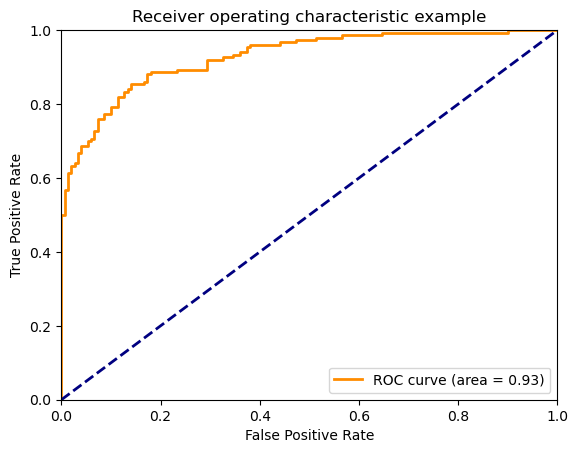

In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve( labels, predictions[:,1] )
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot( fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()